In [17]:
import pandas as pd
import wrangle as w
import explore as e
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from functools import reduce

import matplotlib.pyplot as plt

# importing necessary libraries
import pandas as pd
import numpy as np


from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

## Recreate model data from model.ipynb notebook

In [18]:
# acquire dataframe
df = w.get_perpetrator_df()

# create production dataframe based on the target variables
production_df = df[df['gname'].str.contains('Unknown')==True]

# create target variable dataframe
df1 = df[df['gname'].str.contains('Unknown')==False]

# drop columns from the dataframe that arent relevant in the predictor
model_df = df1.drop(columns=['event_id',
             'month',
             'day',
             'region',
             'latitude',
             'longitude',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])


# change year to object type
model_df.year = model_df.year.astype('str')

data = model_df


### Scaling

In [19]:
# create a dataframe for the gname target variable
gnames = pd.DataFrame(data.gname)

# create nkill df
nkills = pd.DataFrame(data.nkill)

# scale nkill
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(nkills)
nkills = pd.DataFrame(scaler.transform(nkills))
nkills = nkills.rename(columns={0:'nkill'})

In [20]:
data.shape[0], gnames.shape[0], nkills.shape[0]

(13281, 13281, 13281)

### Dummy df

In [21]:
# encode variables
dummy_df = pd.get_dummies(model_df[['country',
                                    'provstate',
                                    'city',
                                    'suicide',
                                    'attack_type', 
                                    'targtype',  
                                    'weaptype',
                                    'year']], dummy_na=False, drop_first=[True, True])

In [22]:
dummy_df = dummy_df.reset_index(drop=True)
dummy_df.index

RangeIndex(start=0, stop=13281, step=1)

In [23]:
gnames = gnames.reset_index(drop=True)
gnames.index

RangeIndex(start=0, stop=13281, step=1)

In [24]:
# add target to dataframe
dummy_df = pd.concat([dummy_df, gnames, nkills], axis=1)

In [25]:
dummy_df.shape

(13281, 3451)

In [26]:
dummy_df

suicide  country_bahrain  country_djibouti  country_egypt  \
0            0                0                 0              0   
1            1                0                 0              0   
2            0                0                 0              0   
3            0                0                 0              0   
4            0                0                 0              0   
...        ...              ...               ...            ...   
13276        0                0                 0              0   
13277        0                0                 0              0   
13278        0                0                 0              0   
13279        0                0                 0              0   
13280        0                0                 0              0   

       country_iran  country_iraq  country_israel  country_jordan  \
0                 0             1               0               0   
1                 0             0               0               0   
2                 0             0               0               0   
3                 0             0               0               0   
4                 0             0               0               0   
...             ...           ...             ...             ...   
13276             0             0               0               0   
13277             0             1               0               0   
13278             0             0               0               0   
13279             0             0               0               0   
13280             0             0               0               0   

       country_lebanon  country_pakistan  country_saudi arabia  \
0                    0                 0                     0   
1                    0                 0                     0   
2                    0                 0                     0   
3                    0                 0                     0   
4                    0                 0                     0   
...                ...               ...                   ...   
13276                0                 0                     0   
13277                0                 0                     0   
13278                0                 0                     0   
13279                0                 0                     0   
13280                0                 0                     0   

       country_somalia  country_syria  country_turkey  provstate_Adiyaman  \
0                    0              0               0                   0   
1                    0              0               0                   0   
2                    0              0               0                   0   
3                    0              0               0                   0   
4                    0              0               0                   0   
...                ...            ...             ...                 ...   
13276                0              0               0                   0   
13277                0              0               0                   0   
13278                1              0               0                   0   
13279                0              0               0                   0   
13280                1              0               0                   0   

       provstate_Agri  provstate_Al Anbar  provstate_Al Hasakah  \
0                   0                   0                     0   
1                   0                   0                     0   
2                   0                   0                     0   
3                   0                   0                     0   
4                   0                   0                     0   
...               ...                 ...                   ...   
13276               0                   0                     0   
13277               0                   0                     0   
13278               0                   

### TTS

In [27]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.27, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.35, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [28]:
# split into train, validate, test
train, validate, test = train_validate_test_split(dummy_df, target='gname', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train= train.drop(columns=['gname'])
y_train = train.gname

X_validate = validate.drop(columns=['gname'])
y_validate = validate.gname

X_test = test.drop(columns=['gname'])
y_test = test.gname

In [42]:
X_train.shape, X_validate.shape, X_test.shape

((6301, 3450), (3394, 3450), (3586, 3450))

In [34]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=3, random_state=123)

# model.fit(X, y)

clf = clf.fit(X_train, y_train)

# make prediction on train obeservations

y_pred = clf.predict(X_train)

y_pred_proba = clf.predict_proba(X_train)

# Eval model
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.82


In [31]:
metrics = []
for i in range(1, 15):
    tree = DecisionTreeClassifier(max_depth=i, random_state=17)
    tree = tree.fit(X_train, y_train)
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
dt_df = pd.DataFrame(metrics)
dt_df["difference"] = dt_df.train_accuracy - dt_df.validate_accuracy
dt_df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.607205,0.606364,0.000841
1,2,0.745437,0.746022,-0.000585
2,3,0.820187,0.819976,0.000211
3,4,0.887002,0.886859,0.000143
4,5,0.931598,0.930760,0.000838
5,6,0.959372,0.957572,0.001799
6,7,0.965402,0.960224,0.005178
7,8,0.967942,0.959929,0.008012
8,9,0.972703,0.959929,0.012773
9,10,0.976036,0.964054,0.011981


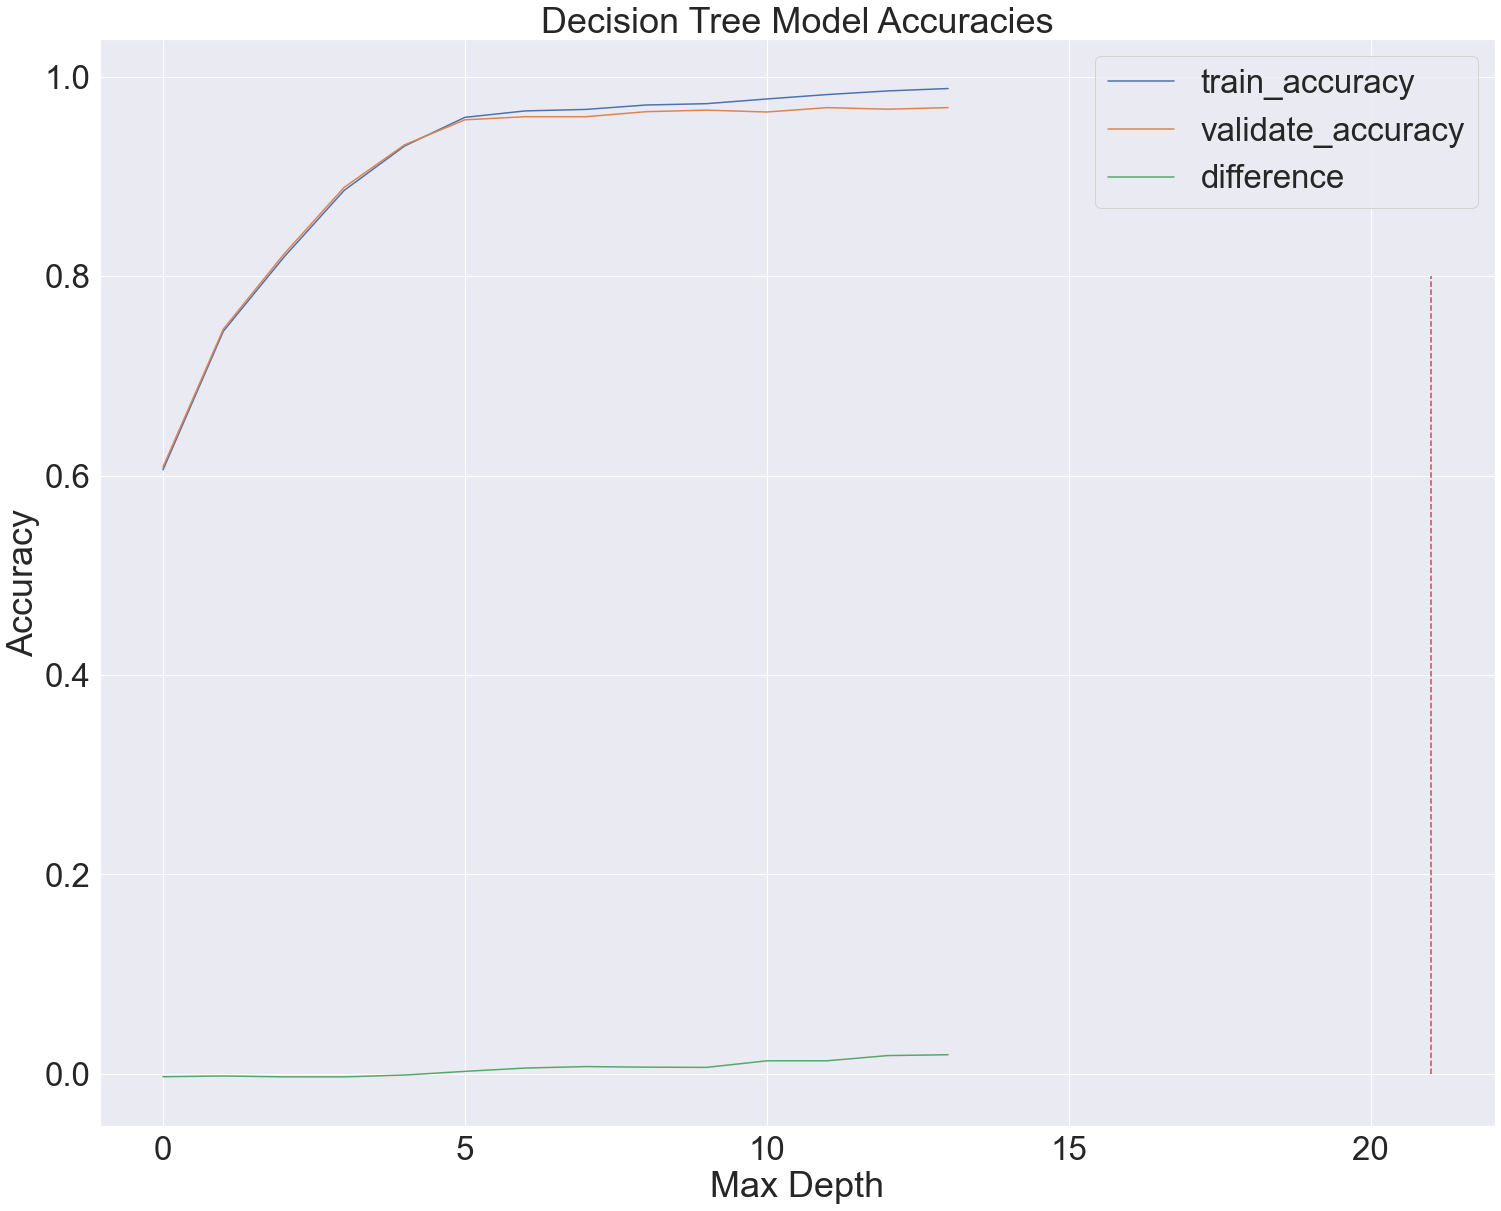

In [16]:
plt.rcParams['figure.figsize'] = [25, 20]
sns.set(font_scale = 3)
dt_df[['train_accuracy', 'validate_accuracy', 'difference' ]].plot()
plt.title("Decision Tree Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.vlines(x=[21], ymin=0, ymax=.8, colors='r', linestyles='dashed')
plt.show()

In [35]:
tree = DecisionTreeClassifier(max_depth=14, random_state=123)

tree = tree.fit(X_train, y_train)

tree.score(X_test, y_test)

0.9662576687116564